In [3]:
import pandas as pd
import numpy as np
import librosa
import soundfile as sf
import os
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
from tqdm.notebook import tqdm

In [2]:
train=pd.read_csv('../Data/train_df.csv')

In [4]:
# --- Define Configuration ---
SAMPLE_RATE = 22050  # Use the same sample rate you used for feature extraction
N_AUGMENTATIONS = 2  # How many augmented versions to create for EACH original audio file

# Create a directory to save the augmented files
AUGMENTED_DIR = 'augmented_audio'
if not os.path.exists(AUGMENTED_DIR):
    os.makedirs(AUGMENTED_DIR)

print(f"Augmented files will be saved to: '{AUGMENTED_DIR}/'")

Augmented files will be saved to: 'augmented_audio/'


In [6]:
# Define the augmentation pipeline
# Each augmentation has a probability 'p' of being applied.
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_shift=-0.5, max_shift=0.5, p=0.5),
])

In [8]:
# This list will hold the new paths and emotions for our augmented data
augmented_data = []

print(f"Starting augmentation process. Creating {N_AUGMENTATIONS} new versions for each audio file...")

# Use tqdm for a nice progress bar
for _, row in tqdm(train.iterrows(), total=len(train)):
    original_path = row['path']
    emotion = row['emotions']
    
    try:
        # Load the original audio file
        audio, sr = librosa.load(original_path, sr=SAMPLE_RATE)
        
        # Create N augmented versions of this file
        for i in range(N_AUGMENTATIONS):
            # Apply the augmentation pipeline
            augmented_samples = augment(samples=audio, sample_rate=sr)
            
            # Create a new filename for the augmented audio
            original_filename = os.path.basename(original_path)
            augmented_filename = f"{os.path.splitext(original_filename)[0]}_aug_{i}.wav"
            augmented_path = os.path.join(AUGMENTED_DIR, augmented_filename)
            
            # Save the augmented audio file
            sf.write(augmented_path, augmented_samples, sr)
            
            # Add the new path and its emotion to our list
            augmented_data.append([augmented_path, emotion])
            
    except Exception as e:
        print(f"Could not process {original_path}. Error: {e}")

print("Augmentation process complete!")

Starting augmentation process. Creating 2 new versions for each audio file...


  0%|          | 0/1470 [00:00<?, ?it/s]

Augmentation process complete!


In [15]:
# Create a DataFrame from the augmented data list
augmented_df = pd.DataFrame(augmented_data, columns=['path', 'emotions'])

print(f"\nNumber of original training samples: {len(train)}")
print(f"Number of newly generated augmented samples: {len(augmented_df)}")

# Combine the original and augmented dataframes
final_train_df = pd.concat([train, augmented_df], ignore_index=True)

# Shuffle the combined dataframe to mix original and augmented data
final_train_df = final_train_df.sample(frac=1).reset_index(drop=True)

print(f"Total size of the new combined training set: {len(final_train_df)}")
print("\nNew training DataFrame head:")
print(final_train_df.head())

# Save the new, combined and shuffled training dataframe to a CSV file
final_train_df.to_csv('../Data/train_augmented.csv', index=False)

print("\nSaved the final augmented training data to 'train_augmented.csv'")


Number of original training samples: 1470
Number of newly generated augmented samples: 2940
Total size of the new combined training set: 4410

New training DataFrame head:
  emotions                                            path type
0      sad  augmented_audio/03-01-04-02-02-02-08_aug_0.wav  NaN
1     calm  augmented_audio/03-02-02-01-01-02-12_aug_1.wav  NaN
2    angry  augmented_audio/03-01-05-01-01-01-09_aug_1.wav  NaN
3     calm  augmented_audio/03-02-02-02-01-02-01_aug_1.wav  NaN
4      sad  augmented_audio/03-02-04-01-01-01-22_aug_1.wav  NaN

Saved the final augmented training data to 'train_augmented.csv'


In [14]:
final_train_df['emotions'].isna().sum()

0

<Axes: xlabel='emotions'>

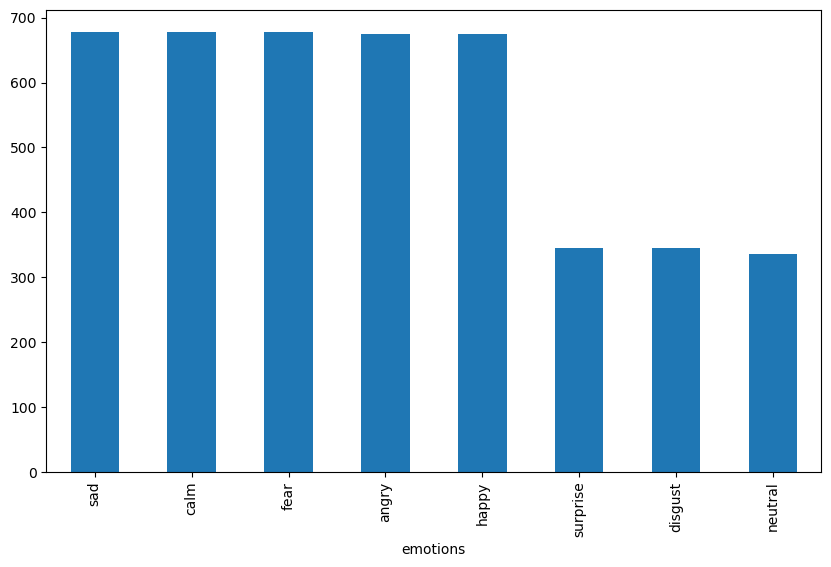

In [16]:
# draw a bar plot of the number of samples in each emotion
from matplotlib import pyplot as plt


plt.figure(figsize=(10, 6))
final_train_df['emotions'].value_counts().plot(kind='bar')  